# Resampling signals on the 2-sphere

## Setup

In [1]:
import os
import math
import numpy as np
import torch
import torch.nn as nn

from torch_harmonics import ResampleS2
from torch_harmonics.quadrature import _precompute_latitudes

import matplotlib.pyplot as plt
from plotting import plot_sphere

let's start by downloading our Mars topography again.

In [2]:
nlat = 257
nlon = 2*(nlat-1)
grid = "equiangular"

xq, wq = _precompute_latitudes(nlat, grid=grid)

In [3]:
os.makedirs("./data", exist_ok=True)
!wget https://astropedia.astrogeology.usgs.gov/download/Mars/GlobalSurveyor/MOLA/thumbs/Mars_MGS_MOLA_DEM_mosaic_global_1024.jpg -O ./data/mola_topo.jpg

import imageio.v3 as iio

img = iio.imread('./data/mola_topo.jpg')
#convert to grayscale
data = np.dot(img[...,:3]/255, [0.299, 0.587, 0.114])
# interpolate onto 512x1024 grid:
data = nn.functional.interpolate(torch.from_numpy(data).unsqueeze(0).unsqueeze(0), size=(nlat,nlon)).squeeze().float()

--2025-01-20 05:35:21--  https://astropedia.astrogeology.usgs.gov/download/Mars/GlobalSurveyor/MOLA/thumbs/Mars_MGS_MOLA_DEM_mosaic_global_1024.jpg
Resolving astropedia.astrogeology.usgs.gov (astropedia.astrogeology.usgs.gov)... 137.227.239.81, 2001:49c8:c000:122d::81
Connecting to astropedia.astrogeology.usgs.gov (astropedia.astrogeology.usgs.gov)|137.227.239.81|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 55192 (54K) [image/jpeg]
Saving to: ‘./data/mola_topo.jpg’

./data/mola_topo.jp 100%[===================>]  53.90K  --.-KB/s    in 0.07s   

2025-01-20 05:35:21 (740 KB/s) - ‘./data/mola_topo.jpg’ saved [55192/55192]



let's plot it:

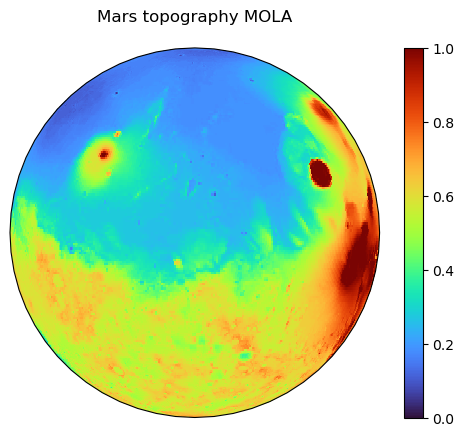

In [4]:
import matplotlib.pyplot as plt
from plotting import plot_sphere

plot_sphere(data, cmap="turbo", colorbar=True, title="Mars topography MOLA")
plt.show()

Let's bring the data to our desired input grid

In [5]:
grid_up = "equiangular"
grid_down = "legendre-gauss"

input_resample = ResampleS2(nlat, nlon, nlat, nlon, grid_in="equiangular", grid_out=grid_up)

data_res = input_resample(data)

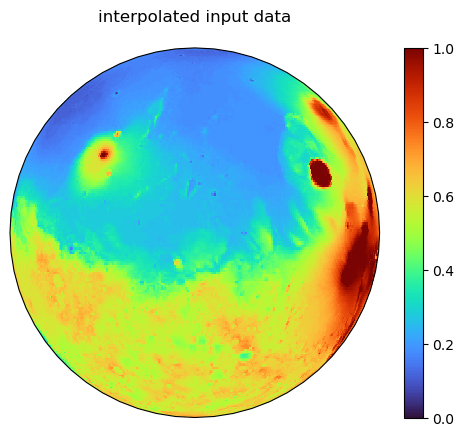

In [6]:
plot_sphere(data_res, cmap="turbo", colorbar=True, title="interpolated input data")

## Resampling

let us define down- and up-sampling layers:

In [7]:
scale_factor = 4

nlat_down = math.ceil(nlat / scale_factor)
nlon_down = math.ceil(nlon / scale_factor)

downsample = ResampleS2(nlat, nlon, nlat_down, nlon_down, grid_in=grid_up)
upsample = ResampleS2(nlat_down, nlon_down, nlat, nlon, grid_in=grid_down)

In [8]:
data_down = downsample(data)
data_up = upsample(data_down)

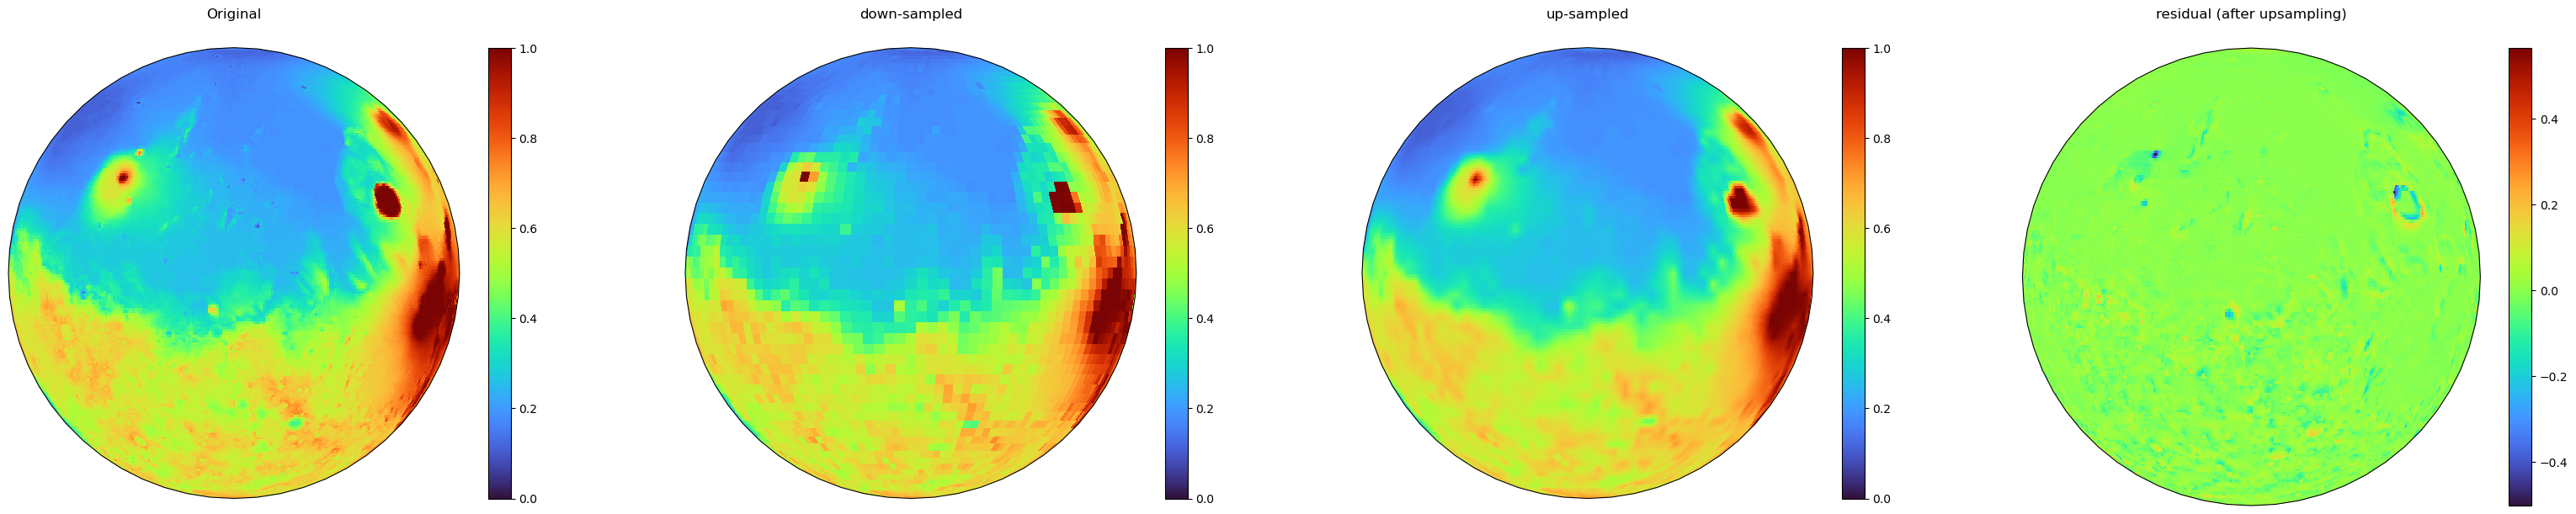

In [9]:
fig = plt.figure(layout='constrained', figsize=(32, 6))
subfigs = fig.subfigures(1, 4)

# spectral fitting
plot_sphere(data, fig=subfigs[0], cmap="turbo", colorbar=True, title="Original")
plot_sphere(data_down, fig=subfigs[1], cmap="turbo", colorbar=True, title="down-sampled")
plot_sphere(data_up, fig=subfigs[2], cmap="turbo", colorbar=True, title="up-sampled")
plot_sphere((data_up - data), fig=subfigs[3], cmap="turbo", colorbar=True, title="residual (after upsampling)")
plt.show()

In [10]:
print((data_up - data).abs().max())

tensor(0.5654)


## Upsampling error

In order to estimate the accuracy of up and down-sampling, let us compare it to idealized SHT upsampling

In [11]:
from torch_harmonics import RealSHT, InverseRealSHT

sht = RealSHT(nlat_down, nlon_down, grid=grid_down)
isht = InverseRealSHT(nlat, nlon, lmax=sht.lmax, mmax=sht.mmax, grid=grid_up)

In [12]:
data_up = upsample(data_down)
data_sht_up = isht(sht(data_down))

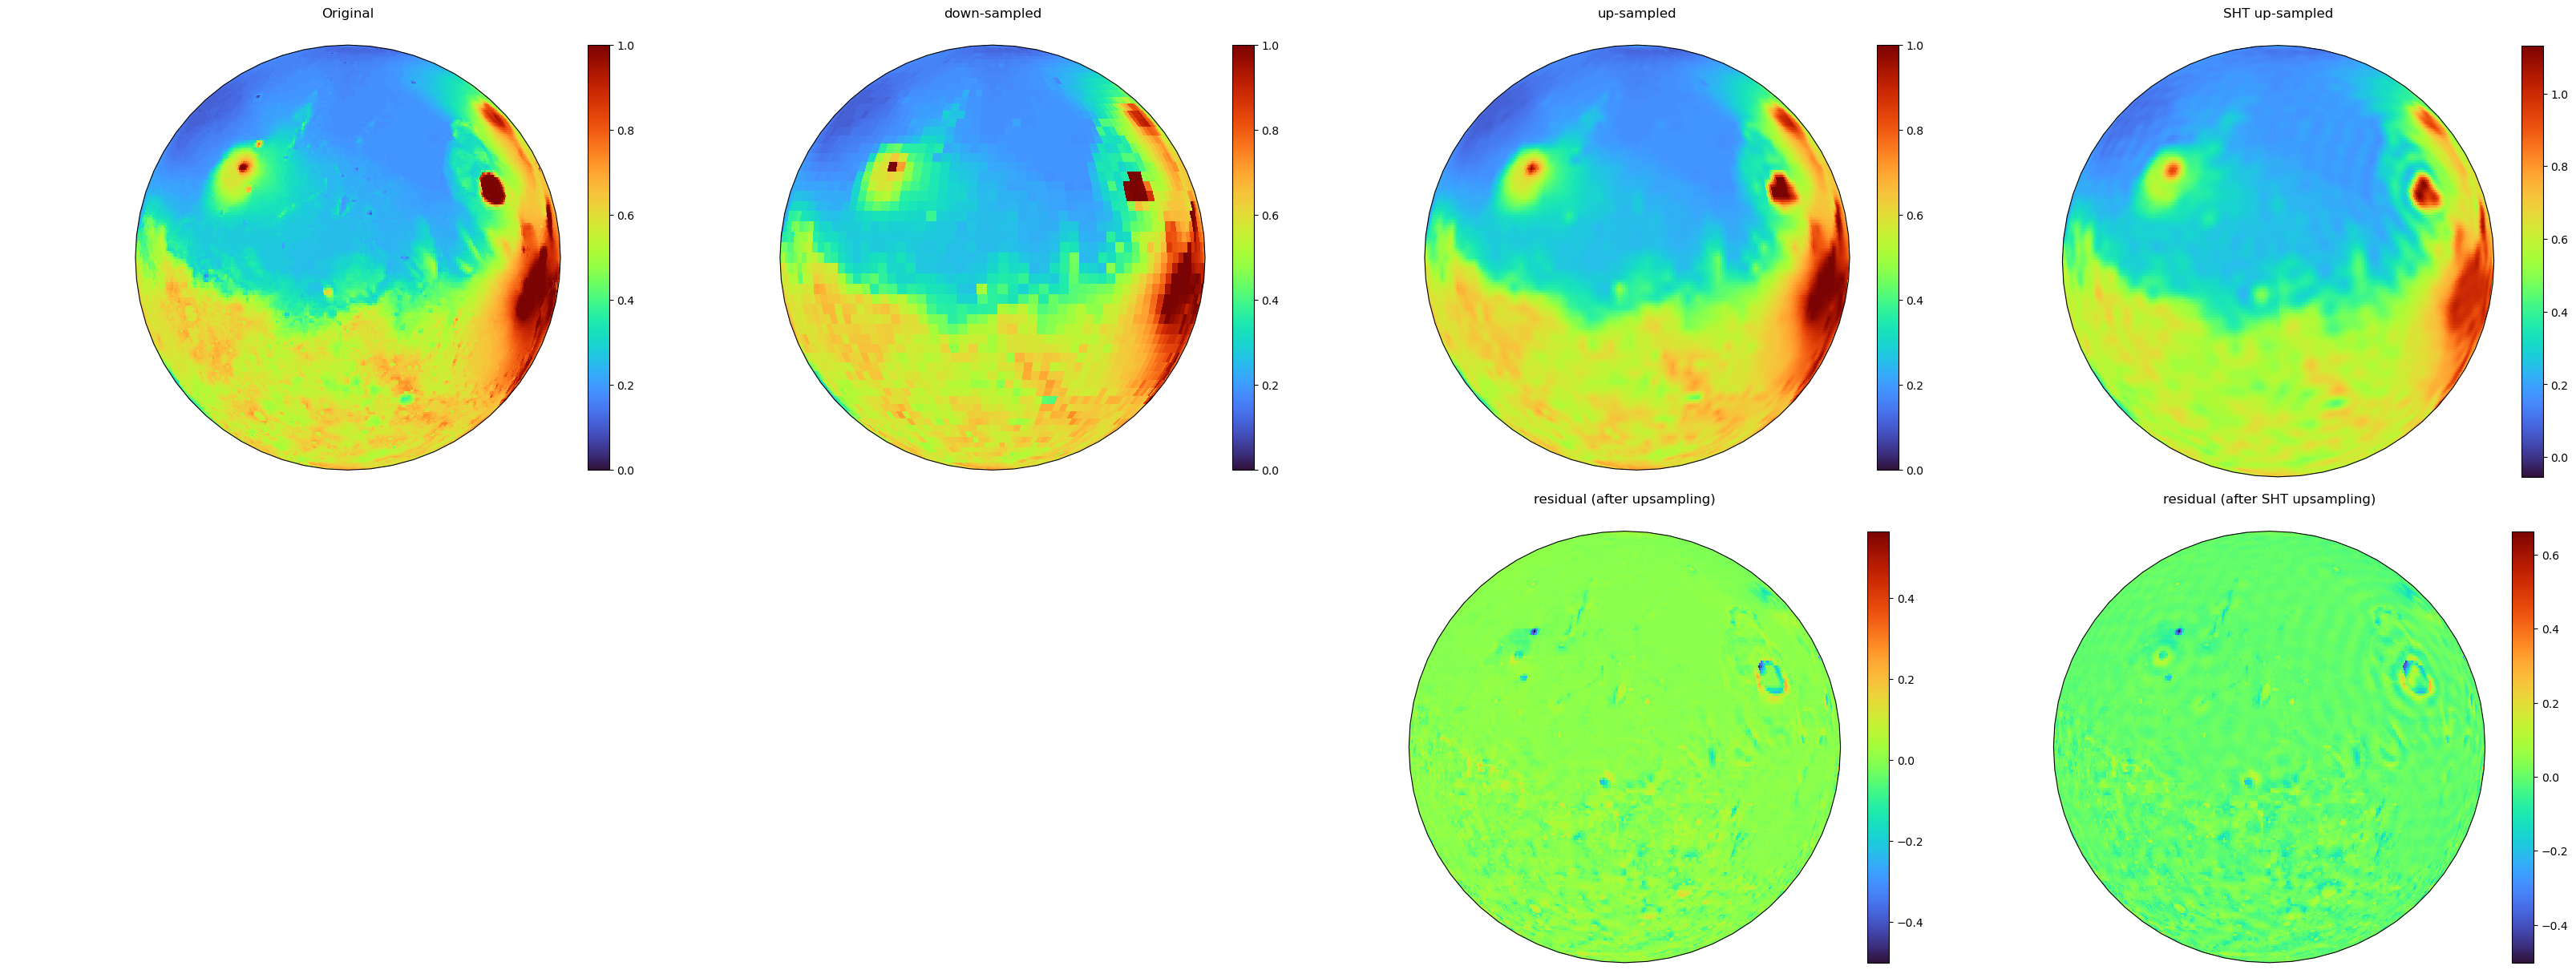

In [13]:
fig = plt.figure(layout='constrained', figsize=(32, 12))
subfigs = fig.subfigures(2, 4)

# spectral fitting
plot_sphere(data, fig=subfigs[0, 0], cmap="turbo", colorbar=True, title="Original")
plot_sphere(data_down, fig=subfigs[0, 1], cmap="turbo", colorbar=True, title="down-sampled")
plot_sphere(data_up, fig=subfigs[0, 2], cmap="turbo", colorbar=True, title="up-sampled")
plot_sphere(data_sht_up, fig=subfigs[0, 3], cmap="turbo", colorbar=True, title="SHT up-sampled")
plot_sphere((data_up - data), fig=subfigs[1, 2], cmap="turbo", colorbar=True, title="residual (after upsampling)")
plot_sphere((data_sht_up - data), fig=subfigs[1, 3], cmap="turbo", colorbar=True, title="residual (after SHT upsampling)")
plt.show()

We see that SHT upsampling suffers from ripples. This can be mitigated by choosing a grid which uses exact quadrature

In [14]:
print((data_up - data).abs().max())
print((data_sht_up - data).abs().max())

tensor(0.5654)
tensor(0.6636)


In [53]:
from functools import cache
from typing import Optional
import torch
import numpy as np
import math

from torch_harmonics.quadrature import legendre_gauss_weights, lobatto_weights, clenshaw_curtiss_weights
from torch_harmonics.legendre import _precompute_legpoly, _precompute_dlegpoly


#@cache
def legpoly_torch(mmax: int, lmax: int, x: torch.Tensor, norm: Optional[str]="ortho", inverse: Optional[bool]=False, csphase: Optional[bool]=True) -> torch.Tensor:
    r"""
    Computes the values of (-1)^m c^l_m P^l_m(x) at the positions specified by x.
    The resulting tensor has shape (mmax, lmax, len(x)). The Condon-Shortley Phase (-1)^m
    can be turned off optionally.

    method of computation follows
    [1] Schaeffer, N.; Efficient spherical harmonic transforms aimed at pseudospectral numerical simulations, G3: Geochemistry, Geophysics, Geosystems.
    [2] Rapp, R.H.; A Fortran Program for the Computation of Gravimetric Quantities from High Degree Spherical Harmonic Expansions, Ohio State University Columbus; report; 1982;
        https://apps.dtic.mil/sti/citations/ADA123406
    [3] Schrama, E.; Orbit integration based upon interpolated gravitational gradients
    """

    # compute the tensor P^m_n:
    nmax = max(mmax,lmax)
    vdm = torch.zeros((nmax, nmax, len(x)), dtype=torch.float64)
        
    norm_factor = 1. if norm == "ortho" else np.sqrt(4 * np.pi)
    norm_factor = 1. / norm_factor if inverse else norm_factor

    # initial values to start the recursion
    vdm[0,0,:] = norm_factor / np.sqrt(4 * np.pi)

    # fill the diagonal and the lower diagonal
    for l in range(1, nmax):
        vdm[l-1, l, :] = np.sqrt(2*l + 1) * x * vdm[l-1, l-1, :]
        vdm[l, l, :] = torch.sqrt( (2*l + 1) * (1 + x) * (1 - x) / 2.0 / l ) * vdm[l-1, l-1, :]

    # fill the remaining values on the upper triangle and multiply b
    for l in range(2, nmax):
        for m in range(0, l-1):
            vdm[m, l, :] = x * np.sqrt((2*l - 1) / (l - m) * (2*l + 1) / float(l + m)) * vdm[m, l-1, :] \
                            - np.sqrt((l + m - 1) / float((l - m) * (2*l + 1)) / float((2*l - 3) * (l - m - 1)) / float(l + m)) * vdm[m, l-2, :]

    if norm == "schmidt":
        for l in range(0, nmax):
            if inverse:
                vdm[:, l, : ] = vdm[:, l, : ] * np.sqrt(2*l + 1)
            else:
                vdm[:, l, : ] = vdm[:, l, : ] / np.sqrt(2*l + 1)

    vdm = vdm[:mmax, :lmax]

    if csphase:
        for m in range(1, mmax, 2):
            vdm[m] *= -1

    return vdm

In [55]:
cost, w = legendre_gauss_weights(10, -1, 1)
tq = np.flip(np.arccos(cost)).copy()
x = torch.from_numpy(tq).clone()
print(torch.isnan(x))
lpt = legpoly_torch(3, 3, x)

lpn = _precompute_legpoly(3, 3, tq)

print(lpn, "\n", lpt)

tensor([False, False, False, False, False, False, False, False, False, False])
[[[ 0.28209479  0.28209479  0.28209479  0.28209479  0.28209479
    0.28209479  0.28209479  0.28209479  0.28209479  0.28209479]
  [ 0.47585318  0.42267213  0.33196122  0.21175808  0.07274038
   -0.07274038 -0.21175808 -0.33196122 -0.42267213 -0.47585318]
  [ 0.58204939  0.39266372  0.12136018 -0.13767009 -0.29442096
   -0.29442096 -0.13767009  0.12136018  0.39266372  0.58204939]]

 [[-0.         -0.         -0.         -0.         -0.
   -0.         -0.         -0.         -0.         -0.        ]
  [-0.07840972 -0.1733215  -0.25350953 -0.31136067 -0.34164401
   -0.34164401 -0.31136067 -0.25350953 -0.1733215  -0.07840972]
  [-0.17075452 -0.33526279 -0.38513319 -0.30174011 -0.11373095
    0.11373095  0.30174011  0.38513319  0.33526279  0.17075452]]

 [[ 0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.  